In [ ]:
import numpy as np
import pandas as pd
import os

directory = "drive/MyDrive/Crime Data 2023 Text"
contents = os.listdir(directory)

dates = []
locations = []
crimes = []
descs = []

def txt_to_df(txt_file):
  with open(txt_file, "r", encoding='latin-1') as file_lines:
    lines = [l.strip() for l in file_lines.readlines() if len(l.strip()) > 0]
  lines = lines[lines.index("COMMENTS")+1:]

  dates = []
  locations = []
  crimes = []
  descs = []

  date_index = 0
  while date_index < len(lines):
    next_date_index = date_index+1
    while next_date_index < len(lines) and not ("/" in lines[next_date_index] and len(lines[next_date_index]) < 10):
      next_date_index += 1

    dates.append(lines[date_index])
    locations.append(lines[date_index+1])
    descs.append(lines[next_date_index-1])

    crime_str = ""
    for i in range(date_index+2, next_date_index-1):
      crime_str += lines[i] + " "
    crimes.append(crime_str.strip())

    date_index = next_date_index

  return dates, locations, crimes, descs

for item in contents:
  da, lo, cr, de = txt_to_df(f"{directory}/{item}")
  dates += da
  locations += lo
  crimes += cr
  descs += de

df = pd.DataFrame({
    "Date":dates,
    "Location":locations,
    "Crime":crimes,
    "Desc":descs
})
df.to_csv("Cupertino Crime.csv", index=False)
df

,Date,Location,Crime,Desc
0,12/25,C2,Injury Collision,Occurred at 3:24 PM at Stevens Creek Boulevard...
1,12/26,C5,Attempted Residential Burglary,"At 2:50 AM, unknown suspect(s) attempted to en..."
2,12/26,C3,Non-Injury Hit and Run Collision,Occurred between 2:00 PM and 4:00 PM in the 21...
3,12/26,C3,Shoplifting,"At 7:58 PM, the suspect entered Target on Stev..."
4,12/27,C3,Non-Injury Hit and Run Collision,Occurred at 2:29 PM at Stevens Creek Boulevard...
...,...,...,...,...
1393,3/10,C5,Vehicle Burglary,"Between 7:15 PM and 7:38 PM, unknown suspect(s..."
1394,3/11,C6,Residential Burglary,"Between 12:46 PM and 9:00 PM, unknown suspect(..."
1395,3/12,C7,Residential Burglary,"Between 3/1/22 and 3/12/23, unknown suspect(s)..."
1396,3/12,C1,Vehicle Burglary,"Between 9:00 PM on 3/8 and 3:50 PM on 3/12, un..."


In [ ]:
def desc_to_money(desc):
  if "$" not in desc: return 0
  desc = desc.replace(",", "")
  total_amount = 0
  while True:
    index_dollar = desc.index("$")

    amount = ""
    index = index_dollar + 1
    while index < len(desc) and desc[index].isnumeric():
      amount += desc[index]
      index += 1
    total_amount += int(amount)

    desc = desc[index:]
    try:
      desc.index("$")
    except ValueError:
      break

  return total_amount

df["Money"] = df["Desc"].apply(lambda d: desc_to_money(d))
df["Money"]

0           0
1           0
2           0
3          45
4           0
        ...  
1393        0
1394    20000
1395        0
1396       80
1397        0
Name: Money, Length: 1398, dtype: int64

In [ ]:
def time_to_int(desc, i):
  time = int(desc[i].split(":")[0]) + float(desc[i].split(":")[1]) / 60
  if "AM" in desc[i+1] and int(desc[i].split(":")[0]) == 12:
      time -= 12
  elif "PM" in desc[i+1] and int(desc[i].split(":")[0]) != 12:
      time += 12
  return time

def desc_to_time(desc):
  desc = desc.replace(",", "")
  desc = desc.split()
  start_time = -1
  end_time = None
  for i in range(len(desc)-1):
    if ":" in desc[i] and ("PM" in desc[i+1] or "AM" in desc[i+1]):
      time = time_to_int(desc, i)
      if start_time == -1: start_time = time
      else: end_time = time

  actual_end_time = end_time

  dates = []
  for i in range(len(desc)):
    if "/" in desc[i] and len(desc[i]) < 10:
      dates.append(desc[i])

  if len(dates) > 1 and end_time != None:
    if int(dates[0].split("/")[0]) == int(dates[-1].split("/")[0]) and len(dates[0].split("/")) == 2:
      length_days = int(dates[-1].split("/")[1]) - int(dates[0].split("/")[1])
      end_time += 24*length_days
    elif int(dates[0].split("/")[0]) == int(dates[-1].split("/")[0]) and len(dates[0].split("/")) == 3:
      length_days = int(dates[-1].split("/")[1]) - int(dates[0].split("/")[1])
      length_years = int(dates[-1].split("/")[2]) - int(dates[0].split("/")[2])
      end_time += length_years*8760 + length_days*24
    elif len(dates[0].split("/")) == 2:
      start_month = int(dates[0].split("/")[0])
      end_month = int(dates[-1].split("/")[0])
      if end_month > start_month: month_dif = end_month - start_month
      else: month_dif = (end_month + 12) - start_month

      start_day = int(dates[0].split("/")[1])
      end_day = int(dates[-1].split("/")[1])
      day_dif = end_day - start_day

      end_time += month_dif*744 + day_dif*24
    else:
      #Manual
      end_time += 408*24

  if start_time == -1: start_time = None

  return [start_time, end_time, actual_end_time]

df["Start Time"] = df["Desc"].apply(lambda d: desc_to_time(d)[0])
df["End Time"] = df["Desc"].apply(lambda d: desc_to_time(d)[1])
df["Actual End Time"] = df["Desc"].apply(lambda d: desc_to_time(d)[2])
df["Duration"] = df["End Time"] - df["Start Time"]

df[["Start Time", "End Time", "Duration"]]

,Start Time,End Time,Duration
0,15.400000,NaN,NaN
1,2.833333,NaN,NaN
2,14.000000,16.000000,2.000000
3,19.966667,NaN,NaN
4,14.483333,NaN,NaN
...,...,...,...
1393,19.250000,19.633333,0.383333
1394,12.766667,21.000000,8.233333
1395,NaN,NaN,NaN
1396,21.000000,111.833333,90.833333


In [ ]:
def get_month_day(date):
  date = date.split("/")
  month = int(date[0])
  day = int(date[1])

  return [month, day]

df["Month"] = df["Date"].apply(lambda d: get_month_day(d)[0])
df["Day"] = df["Date"].apply(lambda d: get_month_day(d)[1])

df[["Date", "Month", "Day"]]

,Date,Month,Day
0,12/25,12,25
1,12/26,12,26
2,12/26,12,26
3,12/26,12,26
4,12/27,12,27
...,...,...,...
1393,3/10,3,10
1394,3/11,3,11
1395,3/12,3,12
1396,3/12,3,12


In [ ]:
df["Arrest"] = df["Crime"].apply(lambda c: "Yes" if "ARREST" in c else "No")
df[["Crime", "Arrest"]]

,Crime,Arrest
0,Injury Collision,No
1,Attempted Residential Burglary,No
2,Non-Injury Hit and Run Collision,No
3,Shoplifting,No
4,Non-Injury Hit and Run Collision,No
...,...,...
1393,Vehicle Burglary,No
1394,Residential Burglary,No
1395,Residential Burglary,No
1396,Vehicle Burglary,No


In [ ]:
def known_suspect(desc):
  desc = desc.lower().strip()
  if "unknown suspect" in desc: return "No"
  else: return "Yes"

df["Known Suspect"] = df["Desc"].apply(lambda d: known_suspect(d))
df[["Desc", "Known Suspect"]]

,Desc,Known Suspect
0,Occurred at 3:24 PM at Stevens Creek Boulevard...,Yes
1,"At 2:50 AM, unknown suspect(s) attempted to en...",No
2,Occurred between 2:00 PM and 4:00 PM in the 21...,Yes
3,"At 7:58 PM, the suspect entered Target on Stev...",Yes
4,Occurred at 2:29 PM at Stevens Creek Boulevard...,Yes
...,...,...
1393,"Between 7:15 PM and 7:38 PM, unknown suspect(s...",No
1394,"Between 12:46 PM and 9:00 PM, unknown suspect(...",No
1395,"Between 3/1/22 and 3/12/23, unknown suspect(s)...",No
1396,"Between 9:00 PM on 3/8 and 3:50 PM on 3/12, un...",No


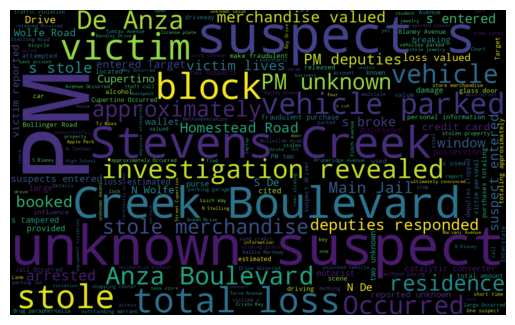

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(list(np.array(df["Desc"].apply(lambda t: t.strip())))).strip()
wordcloud = WordCloud(width=1300, height=800).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

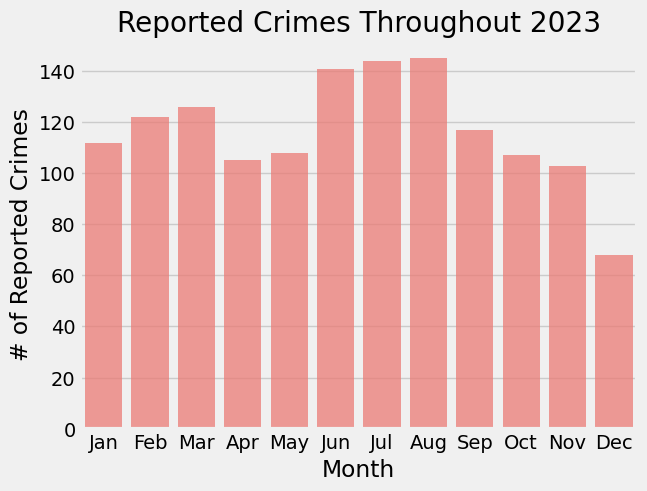

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")

number2month = {1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep",
                10:"Oct", 11:"Nov", 12:"Dec"}

month_df = df.sort_values(by="Month")
month_df["Month"] = month_df["Month"].apply(lambda num: number2month[num])

months = list(number2month.values())
count = [month_df[month_df["Month"] == m].shape[0] for m in months]
#count[0] = 78
#count[1] = 66

sns.barplot(x=months, y = count, color="#FF6961", alpha=0.75)
plt.xlabel("Month")
plt.ylabel("# of Reported Crimes")
plt.title("Reported Crimes Throughout 2023")
plt.show()

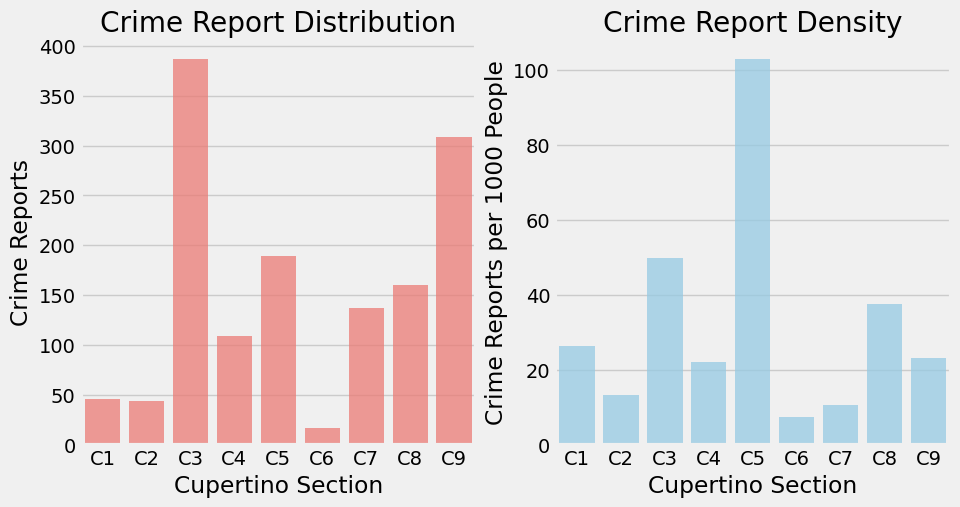

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

populations_2020 = [1953, 3761, 8701, 5522, 2060, 2608, 14464, 4785, 14950]
pops_2024 = [num - (10.93/100)*num for num in populations_2020]

sections = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
section_crimes = [df[df["Location"] == s].shape[0] for s in sections]
section_crimes_per1000 = [section_crimes[i] / pops_2024[i] * 1000 for i in range(len(sections))]

sns.barplot(ax=ax[0], x=sections, y=section_crimes, color="#FF6961", alpha=0.75)
sns.barplot(ax=ax[1], x=sections, y=section_crimes_per1000, color="#89CFF0", alpha=0.75)
ax[0].set_xlabel("Cupertino Section")
ax[1].set_xlabel("Cupertino Section")
ax[0].set_ylabel("Crime Reports")
ax[1].set_ylabel("Crime Reports per 1000 People")
ax[0].set_title("Crime Report Distribution")
ax[1].set_title("Crime Report Density")
plt.show()

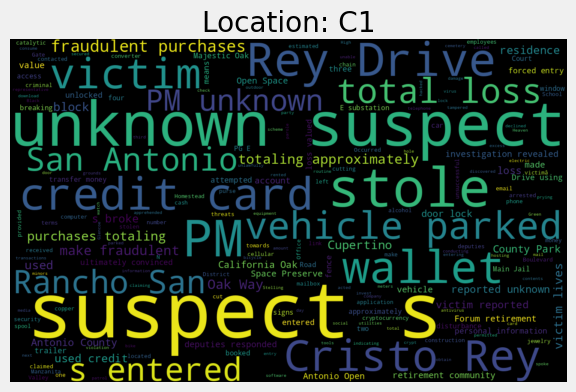

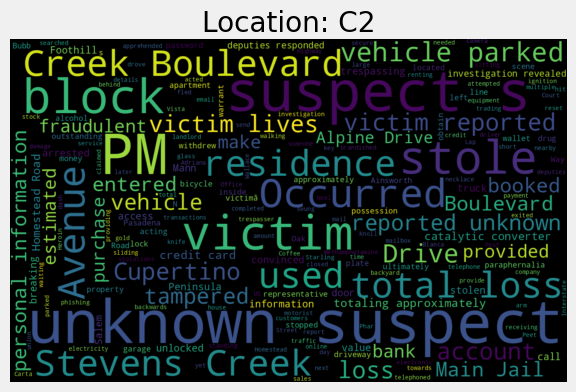

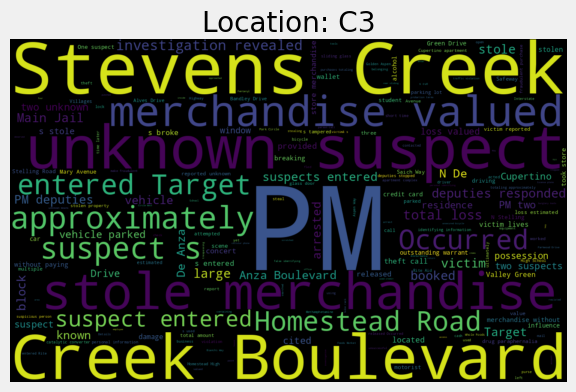

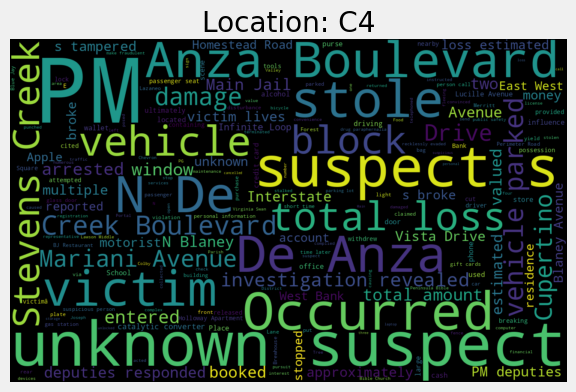

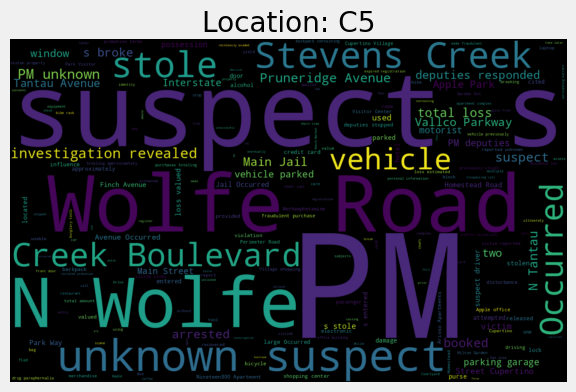

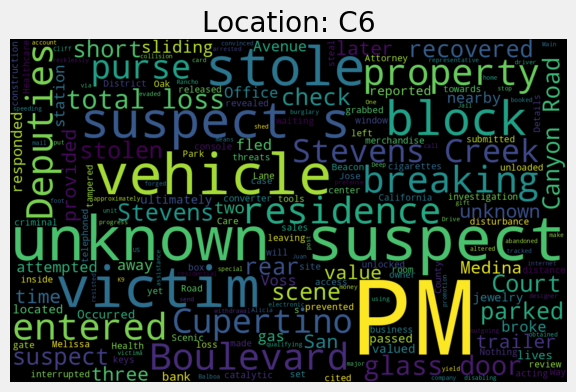

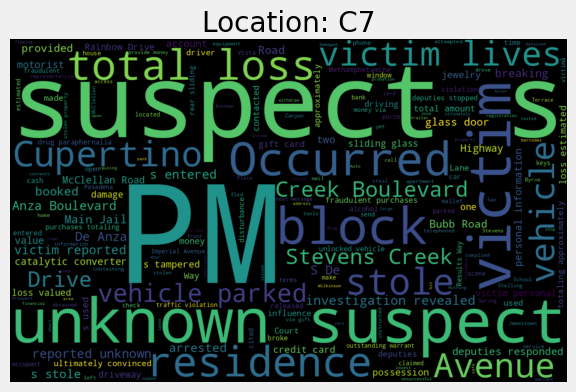

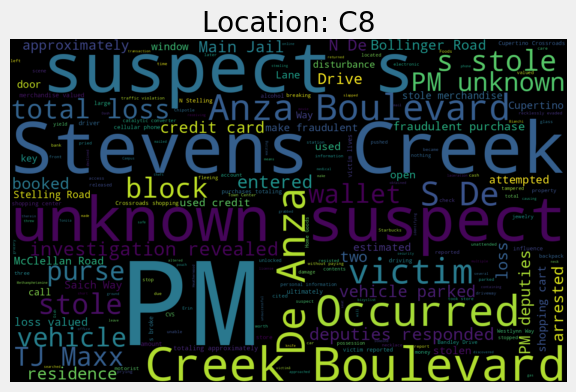

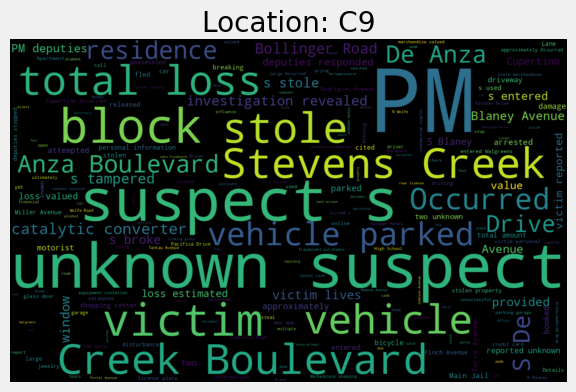

In [ ]:
def generate_wordcloud(cluster):
  text = " ".join(list(np.array(df[df["Location"] == cluster]["Desc"].apply(lambda t: t.strip())))).strip()
  wordcloud = WordCloud(width=1300, height=800).generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Location: {cluster}")
  plt.show()

for cluster in sections:
  generate_wordcloud(cluster)

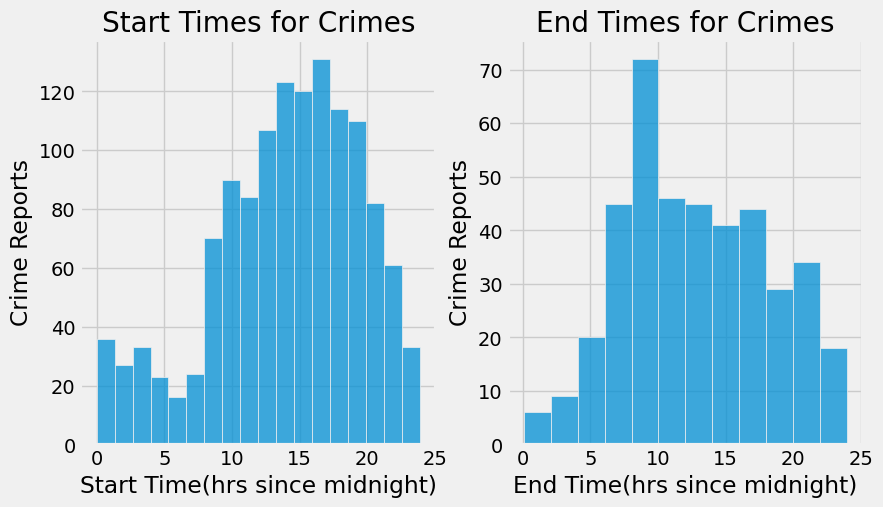

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))

sns.histplot(ax=ax[0], x=df["Start Time"])
sns.histplot(ax=ax[1], x=df[df["Actual End Time"].notna()]["Actual End Time"])
ax[0].set_xlabel("Start Time(hrs since midnight)")
ax[1].set_xlabel("End Time(hrs since midnight)")
ax[0].set_ylabel("Crime Reports")
ax[1].set_ylabel("Crime Reports")
ax[0].set_title("Start Times for Crimes")
ax[1].set_title("End Times for Crimes")
plt.show()

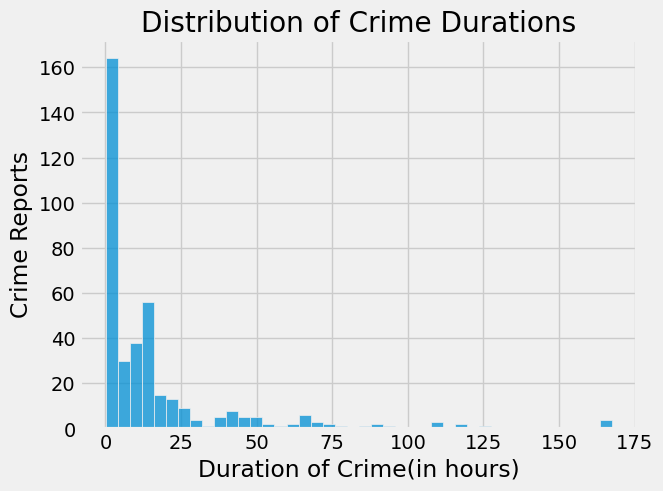

In [ ]:
#NOTE: Crimes that are longer than one week are left out because they are outliers
sns.histplot(x=df[(df["Duration"].notna()) & (df["Duration"] < 24*7)]["Duration"])
plt.xlabel("Duration of Crime(in hours)")
plt.ylabel("Crime Reports")
plt.title("Distribution of Crime Durations")
plt.show()

In [ ]:
crimes = np.unique(df["Crime"])
crimes = [c.split(",") for c in crimes]
type_crimes = []
for c in crimes:
  for l in c:
    type_crimes.append(l.replace("ARREST", "").strip())
type_crimes = np.unique(type_crimes)

print(list(type_crimes))

['Animal Cruelty', 'Annoying or Harassing Phone Calls', 'Arson', 'Assault Likely to Cause Great Bodily Injury', 'Assault and Battery', 'Assault and Battery with a Deadly Weapon Causing Serious Injury', 'Assault by Means Likely to Cause Great Bodily Injury', 'Assault with Deadly Weapon', 'Assault with Force Likely to Produce Great Bodily Injury', 'Assault with a Deadly Weapon', 'Attempted Auto Theft', 'Attempted Commercial Burglary', 'Attempted Grand Theft', 'Attempted Residential Burglary', 'Attempted Robbery', 'Attempted Theft by Credit Card', 'Attempted Vehicle Burglary', 'Attempted Vehicle Theft', 'Auto Theft', 'Battery', 'Battery Causing Serious Bodily Injury', 'Battery and Disturbing the Peace on School Campus', 'Battery on Emergency Personnel', 'Battery on School Employees', 'Battery on School Grounds', 'Battery on School Property', 'Battery on School Property Causing Serious Injury', 'Battery on a Peace Officer', 'Brandishing a Deadly Weapon', 'Brandishing a Weapon', 'Brandishin

In [ ]:
with open("drive/MyDrive/crimegrouping.txt", "r") as groupings: #Gotten from Chat GPT(w/ corrections)
  lines = groupings.readlines()
  lines = [l.strip() for l in lines if len(l.strip()) > 0]

all_classes = [l[:-1] for l in lines if ":" in l]
index_classes = [i for i in range(len(lines)) if ":" in lines[i]] + [len(lines)]
crime2class = {}

for i in range(len(index_classes)-1):
  crimes_i = lines[index_classes[i]+1:index_classes[i+1]]
  for c in crimes_i:
    crime2class[c] = all_classes[i]

crime2class["Possession of Stun Gun"] = "Miscellaneous Crimes"
crime2class["Vehicle Theft Between 5:00 PM on 7/22 and 7:00 AM on 7/24"] = "Property Crimes"
crime2class["Driving with a Suspended Driverâ\x80\x99s License"] = "Road-Related Crimes"

other_crimes = ['Annoying or Harassing Phone Calls', 'Attempted Auto Theft', 'Battery on School Grounds',
                'Child Endangerment', 'Conspiracy', 'Elder Abuse', 'Elder Fraud', 'Minor Injury Collision',
                'Non-Injury Hit-and-Run Collision', 'Shooting at Inhabited Dwelling', 'Theft by Access Card']
other_classes = ["Miscellaneous Crimes", "Property Crimes", "Violent Crimes", "Violent Crimes",
                 "Miscellaneous Crimes", "Violent Crimes", "Property Crimes", "Road-Related Crimes",
                 "Road-Related Crimes", "Violent Crimes", "Property Crimes"]

for i in range(len(other_crimes)):
  crime2class[other_crimes[i]] = other_classes[i]

a = [c for c in type_crimes if c not in list(crime2class.keys())]
print(a)

[]


In [ ]:
def crime_to_class_tf(crime, cls):
  crime = crime.replace("ARREST", "").strip()
  if "," not in crime:
    if crime2class[crime] == cls: return 1
    else: return 0
  else:
    these_crimes = crime.split(",")
    crimes_tf = [crime2class[cr.strip()] == cls for cr in these_crimes if len(cr.strip()) > 0]
    if True in crimes_tf: return 1
    else: return 0

crime_types = ["Violent", "Property", "Substance", "Road-Related", "Miscellaneous"]
crime_names = ["Violent Crimes", "Property Crimes", "Drug and Substance-Related Crimes", "Road-Related Crimes", "Miscellaneous Crimes"]
for i in range(len(crime_types)):
  df[crime_types[i]] = df["Crime"].apply(lambda c: crime_to_class_tf(c, crime_names[i]))

df[["Crime", "Violent", "Property", "Substance", "Road-Related", "Miscellaneous"]]

,Crime,Violent,Property,Substance,Road-Related,Miscellaneous
0,Injury Collision,0,0,0,1,0
1,Attempted Residential Burglary,0,1,0,0,0
2,Non-Injury Hit and Run Collision,0,0,0,1,0
3,Shoplifting,0,1,0,0,0
4,Non-Injury Hit and Run Collision,0,0,0,1,0
...,...,...,...,...,...,...
1393,Vehicle Burglary,0,1,0,0,0
1394,Residential Burglary,0,1,0,0,0
1395,Residential Burglary,0,1,0,0,0
1396,Vehicle Burglary,0,1,0,0,0


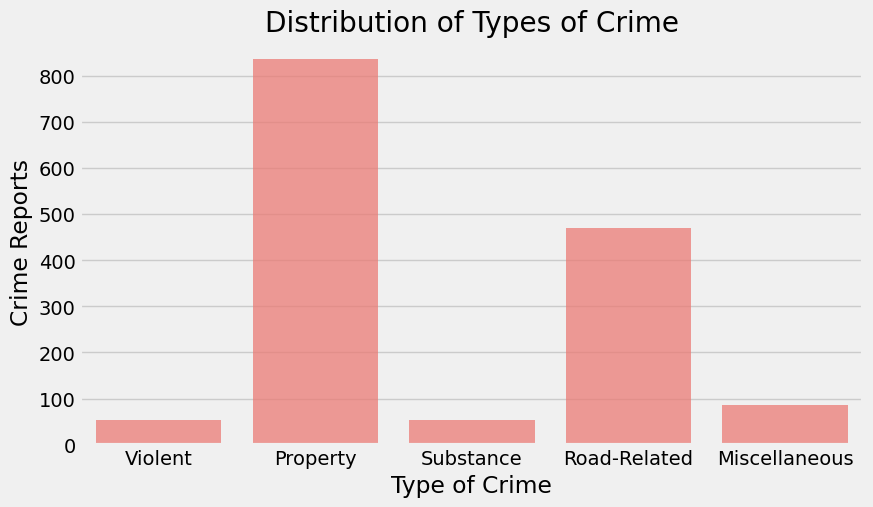

In [ ]:
crime_counts = [df[df[t] == 1].shape[0] for t in crime_types]

plt.figure(figsize=(9,5))
sns.barplot(x=crime_types, y=crime_counts, color="#FF6961", alpha=0.75)
plt.xlabel("Type of Crime")
plt.ylabel("Crime Reports")
plt.title("Distribution of Types of Crime")
plt.show()

Percentage of Crime Reports with $0 lost: 53.934191702432045%
Percent of Crime Reports with >$10,000 lost: 5.221745350500715%


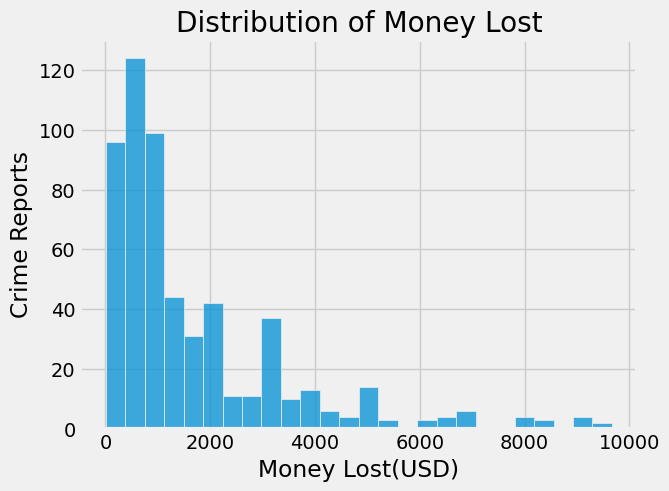

In [ ]:
percent_no_money = df[df["Money"] == 0].shape[0] / df.shape[0] * 100
percent_over_10k = df[df["Money"] >= 10000].shape[0] / df.shape[0] * 100

print(f"Percentage of Crime Reports with $0 lost: {percent_no_money}%")
print(f"Percent of Crime Reports with >$10,000 lost: {percent_over_10k}%")

sns.histplot(x=df[(df["Money"] > 0) & (df["Money"] < 10000)]["Money"])
plt.xlabel("Money Lost(USD)")
plt.ylabel("Crime Reports")
plt.title("Distribution of Money Lost")
plt.show()

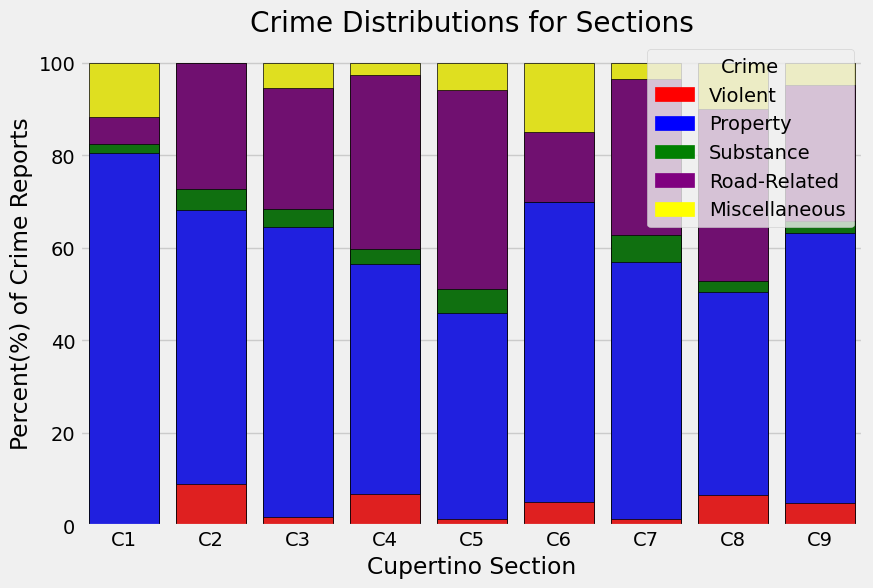

In [ ]:
import matplotlib.patches as mpatches

sec_dists = []
for sec in sections:
  dist = [df[(df["Location"] == sec) & (df[cr] == 1)].shape[0] for cr in crime_types]
  sec_dists.append(dist)

prop_sec_dists = [[sec_dist[i] / sum(sec_dist) * 100 for i in range(len(sec_dist))] for sec_dist in sec_dists]

plt.figure(figsize=(9,6))
sns.barplot(x=sections, y=[d[0]+d[1]+d[2]+d[3]+d[4] for d in prop_sec_dists], color="yellow", edgecolor="black")
sns.barplot(x=sections, y=[d[0]+d[1]+d[2]+d[3] for d in prop_sec_dists], color="purple", edgecolor="black")
sns.barplot(x=sections, y=[d[0]+d[1]+d[2] for d in prop_sec_dists], color="green", edgecolor="black")
sns.barplot(x=sections, y=[d[0]+d[1] for d in prop_sec_dists], color="blue", edgecolor="black")
sns.barplot(x=sections, y=[d[0] for d in prop_sec_dists], color="red", edgecolor="black")

bar0 = mpatches.Patch(color='red', label='Violent')
bar1 = mpatches.Patch(color='blue', label='Property')
bar2 = mpatches.Patch(color='green', label='Substance')
bar3 = mpatches.Patch(color='purple', label='Road-Related')
bar4 = mpatches.Patch(color='yellow', label='Miscellaneous')
plt.legend(title="Crime", handles=[bar0, bar1, bar2, bar3, bar4])

plt.xlabel("Cupertino Section")
plt.ylabel("Percent(%) of Crime Reports")
plt.title("Crime Distributions for Sections")
plt.show()

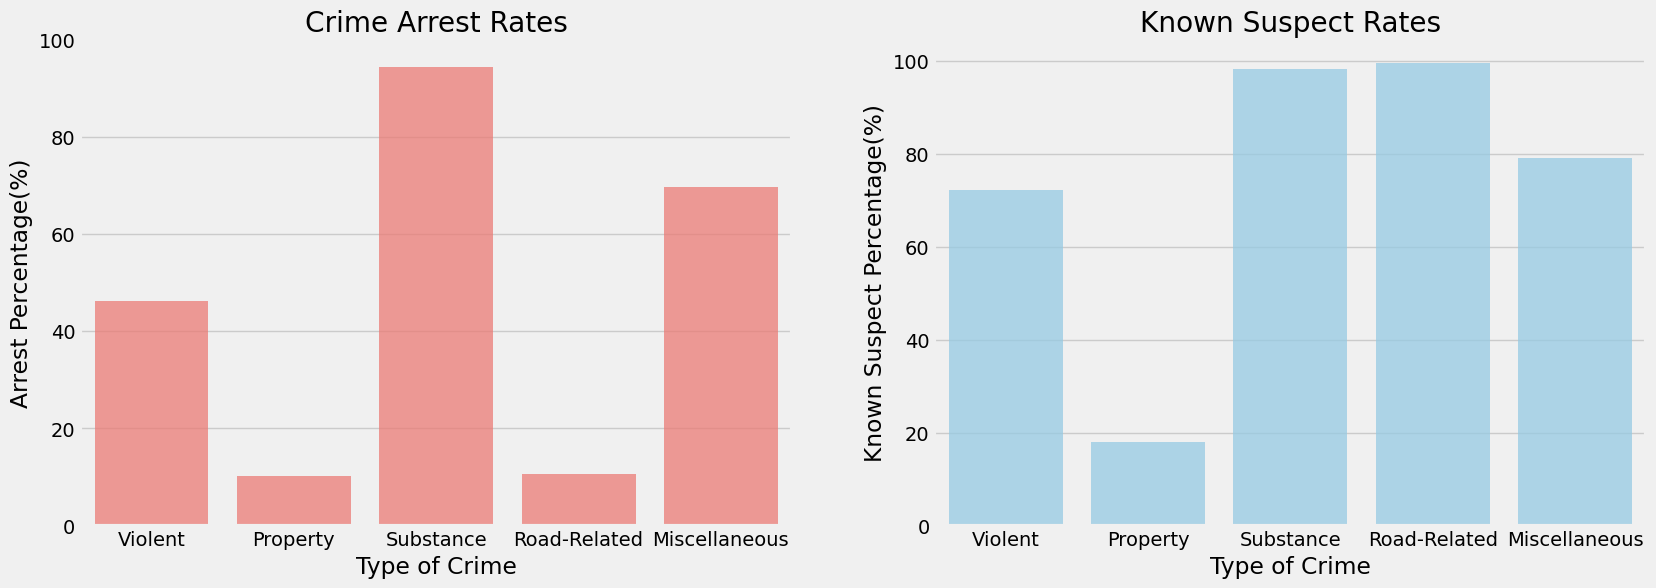

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

arrest_pt = [df[(df[ty] == 1) & (df["Arrest"] == "Yes")].shape[0] / df[df[ty] == 1].shape[0] * 100 for ty in crime_types]
known_pt = [df[(df[ty] == 1) & (df["Known Suspect"] == "Yes")].shape[0] / df[df[ty] == 1].shape[0]
                   * 100 for ty in crime_types]

sns.barplot(ax=ax[0], x=crime_types, y=arrest_pt, color="#FF6961", alpha=0.75)
sns.barplot(ax=ax[1], x=crime_types, y=known_pt, color="#89CFF0", alpha=0.75)
ax[0].set_ylim([0,100])
ax[0].set_xlabel("Type of Crime")
ax[1].set_xlabel("Type of Crime")
ax[0].set_ylabel("Arrest Percentage(%)")
ax[1].set_ylabel("Known Suspect Percentage(%)")
ax[0].set_title("Crime Arrest Rates")
ax[1].set_title("Known Suspect Rates")
plt.show()

Losses due to Crypto Frauds: $2986600
Total losses due to fraudulent contacts: $3667784


<ipython-input-20-7645260b76bc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=[i for i in range(1, money.shape[0]+1)], y=money, log=True, palette=col_colors)
<ipython-input-20-7645260b76bc>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(np.array(dates), rotation=65)


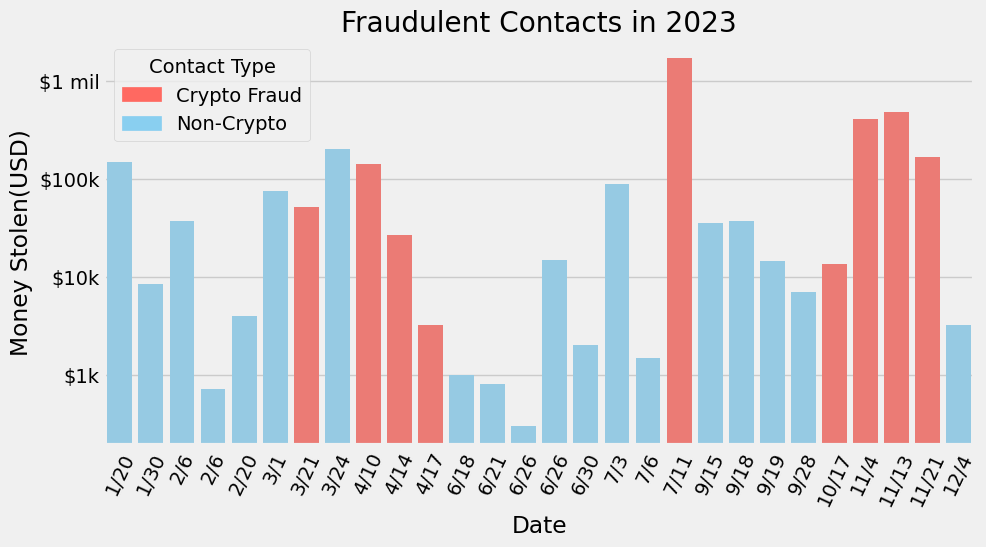

In [ ]:
pd.options.display.max_colwidth = 400

keyword = ["texted", "phoned", "contacted", "email", "crypto"]

df["Fraud Contact"] = df["Desc"].apply(lambda d: "Yes" if True in [word in d for word in keyword] and "unknown suspect" in d else "No")
df["Crypto"] = df["Desc"].apply(lambda d: "Yes" if "crypto" in d.lower() else "No")

df["Datetime"] = pd.to_datetime(df["Date"].apply(lambda d:d+"/23"))
df_sorted = df.sort_values(by="Datetime")

dates = df_sorted[(df_sorted["Fraud Contact"] == "Yes") & (df_sorted["Money"] > 0)]["Date"]
money = df_sorted[(df_sorted["Fraud Contact"] == "Yes") & (df_sorted["Money"] > 0)]["Money"]

col_colors = ["#89CFF0" for i in range(dates.shape[0])]
for i in range(dates.shape[0]):
  date_this = np.array(dates)[i]
  money_this = np.array(money)[i]
  is_crypto = df_sorted[(df_sorted["Date"] == date_this) & (df_sorted["Money"] == money_this)]["Crypto"].to_string()
  if "Yes" in is_crypto: col_colors[i] = "#FF6961"

crypto_losses = df[df["Crypto"] == "Yes"]["Money"]
print(f"Losses due to Crypto Frauds: ${sum(np.array(crypto_losses))}")
print(f"Total losses due to fraudulent contacts: ${sum(np.array(money))}")

plt.figure(figsize=(10,5))

plot = sns.barplot(x=[i for i in range(1, money.shape[0]+1)], y=money, log=True, palette=col_colors)
plt.xlabel("Date")
plt.ylabel("Money Stolen(USD)")
plt.title("Fraudulent Contacts in 2023")

plot.set_xticklabels(np.array(dates), rotation=65)
plot.set_yticks([1000, 10000, 100000, 1000000])
plot.set_yticklabels(["$1k", "$10k", "$100k", "$1 mil"])

barRed = mpatches.Patch(color="#FF6961", label="Crypto Fraud")
barBlue = mpatches.Patch(color="#89CFF0", label="Non-Crypto")
plt.legend(title="Contact Type", handles=[barRed, barBlue])

plt.show()

In [ ]:
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dates = []
for i in range(1, len(days_in_month)+1):
  month_dates = [f"{i}/{d}" for d in range(1, days_in_month[i-1]+1)]
  dates += month_dates
days = ["Sunday"]

all_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i in range(1, len(dates)):
  prev_day = days[i-1]
  prev_day_index = all_days.index(prev_day)
  if prev_day_index < 6:
    days.append(all_days[prev_day_index+1])
  else:
    days.append("Monday")

date2day = {date: day for date, day in zip(dates, days)}
df["Day of Week"] = df["Date"].map(date2day)
df[["Date", "Day of Week"]]

,Date,Day of Week
0,12/25,Monday
1,12/26,Tuesday
2,12/26,Tuesday
3,12/26,Tuesday
4,12/27,Wednesday
...,...,...
1393,3/10,Friday
1394,3/11,Saturday
1395,3/12,Sunday
1396,3/12,Sunday


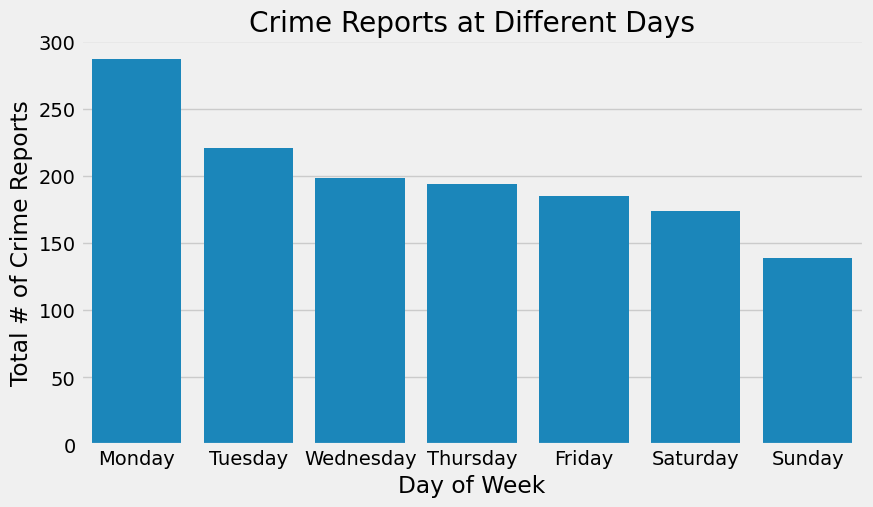

In [ ]:
day_crimes = [df[(df["Day of Week"] == day)].shape[0] for day in all_days]

plt.figure(figsize=(9,5))
sns.barplot(x=all_days, y=day_crimes)
plt.xlabel("Day of Week")
plt.ylabel("Total # of Crime Reports")
plt.title("Crime Reports at Different Days")
plt.show()

In [ ]:
df

,Date,Location,Crime,Desc,Money,Start Time,End Time,Actual End Time,Duration,Month,...,Known Suspect,Violent,Property,Substance,Road-Related,Miscellaneous,Fraud Contact,Crypto,Datetime,Day of Week
0,12/25,C2,Injury Collision,Occurred at 3:24 PM at Stevens Creek Boulevard and Peninsula Avenue.,0,15.400000,NaN,NaN,NaN,12,...,Yes,0,0,0,1,0,No,No,2023-12-25,Monday
1,12/26,C5,Attempted Residential Burglary,"At 2:50 AM, unknown suspect(s) attempted to enter an occupied hotel room at the Courtyard by Marriott on N. Wolfe Road by inserting a tool under the door to pry or force it open, but were unsuccessful and did not gain entry.",0,2.833333,NaN,NaN,NaN,12,...,No,0,1,0,0,0,No,No,2023-12-26,Tuesday
2,12/26,C3,Non-Injury Hit and Run Collision,Occurred between 2:00 PM and 4:00 PM in the 21000 block of Stevens Creek Boulevard.,0,14.000000,16.000000,16.000000,2.000000,12,...,Yes,0,0,0,1,0,No,No,2023-12-26,Tuesday
3,12/26,C3,Shoplifting,"At 7:58 PM, the suspect entered Target on Stevens Creek Boulevard and stole merchandise valued at approximately $45. The suspect is known and at large.",45,19.966667,NaN,NaN,NaN,12,...,Yes,0,1,0,0,0,No,No,2023-12-26,Tuesday
4,12/27,C3,Non-Injury Hit and Run Collision,Occurred at 2:29 PM at Stevens Creek Boulevard and Stelling Road.,0,14.483333,NaN,NaN,NaN,12,...,Yes,0,0,0,1,0,No,No,2023-12-27,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,3/10,C5,Vehicle Burglary,"Between 7:15 PM and 7:38 PM, unknown suspect(s) broke through the windows of multiple vehicles parked at Main Street Cupertino on Stevens Creek Boulevard. Nothing was reported stolen.",0,19.250000,19.633333,19.633333,0.383333,3,...,No,0,1,0,0,0,No,No,2023-03-10,Friday
1394,3/11,C6,Residential Burglary,"Between 12:46 PM and 9:00 PM, unknown suspect(s) entered a residence in the 22000 block of Medina Court by breaking a rear glass door and stole designer purses for a total loss valued at $20,000.",20000,12.766667,21.000000,21.000000,8.233333,3,...,No,0,1,0,0,0,No,No,2023-03-11,Saturday
1395,3/12,C7,Residential Burglary,"Between 3/1/22 and 3/12/23, unknown suspect(s) entered a residence in the 21000 block of Terrace Drive by breaking a glass door. Nothing was reported stolen.",0,NaN,NaN,NaN,NaN,3,...,No,0,1,0,0,0,No,No,2023-03-12,Sunday
1396,3/12,C1,Vehicle Burglary,"Between 9:00 PM on 3/8 and 3:50 PM on 3/12, unknown suspect(s) broke through a window of a vehicle parked at Majestic Oak and California Oak Ways and stole canned foods for a total loss of about $80.",80,21.000000,111.833333,15.833333,90.833333,3,...,No,0,1,0,0,0,No,No,2023-03-12,Sunday
